In [1]:
import pandas as pd
import numpy as np

from keras.layers import Dropout
from keras import regularizers, optimizers
from keras.layers import Input, Conv1D, Dense, Flatten, Activation, UpSampling1D, MaxPooling1D, ZeroPadding1D, TimeDistributed
from keras.models import Model, load_model
from keras.layers.core import Reshape

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model


# Dataset
We use the ECG dataset available [here](https://www.kaggle.com/shayanfazeli/heartbeat/data?select=mitbih_train.csv). There is [an article](https://arxiv.org/pdf/1805.00794.pdf) that uses the dataset, which we can use as a reference. More details about the dataset can be found [here](https://physionet.org/content/apnea-ecg/1.0.0/)

1. Train only on normal cases. --> determine average error.
2. Use the error as the threshold for decisions
3. Check if the error differs significantly for other classes.

## Load the datasets

In [2]:
train = pd.read_csv('data/mitbih_train.csv', low_memory=False, header=None)
train.shape

(87554, 188)

In [3]:
test = pd.read_csv('data/mitbih_test.csv', low_memory=False, header=None)
test.shape

(21892, 188)

In [4]:
normal = pd.read_csv('data/ptbdb_normal.csv',low_memory=False, header=None)
normal.shape

(4046, 188)

In [5]:
abnormal = pd.read_csv('data/ptbdb_abnormal.csv', low_memory=False, header=None)
abnormal.shape

(10506, 188)

## Split into X and y

In [6]:
labels=np.where(train[187]==0)

In [25]:
X_train = train.to_numpy()[:,0:186]
y_train = train.to_numpy()[:,-1]#.reshape(-1,1)

#X_normal = train[train[187]==0]

X_train=X_train.reshape(-1,186,1)
X_train_normal = X_train[y_train == 0]
X_train_normal = X_train_normal[0:5000]
X_train_anomaly = X_train[y_train== 1]
X_train_anomaly2 = X_train[y_train== 2]
X_train_anomaly3 = X_train[y_train== 3]
X_train_anomaly4 = X_train[y_train== 4]


# TEST data
X_test = test.to_numpy()[:,0:186].reshape(-1,186,1)
y_test = test.to_numpy()[:,-1]#.reshape(-1,1)

X_test_normal = X_test[y_test == 0]
X_test_anomaly = X_test[y_test == 1]
X_test_anomaly2 = X_test[y_test == 2]
X_test_anomaly3 = X_test[y_test == 3]
X_test_anomaly4 = X_test[y_test == 4]

In [7]:
len(labels[0])

72471

In [10]:
len(np.where(train[187]==1)[0])

2223

In [23]:
X_normal = train[train[187]==0]

In [45]:
X_train.shape

(87554, 186, 1)

In [46]:
X_train_normal.shape

(5000, 186, 1)

## Train

In [8]:
def LSTM_AE(input_shape):
        
    inputs = Input(shape=input_shape)
    encoded = LSTM(32, activation='tanh', return_sequences=True)(inputs)
    encoded = LSTM(16, activation='tanh', return_sequences=False)(encoded)
        
    decoded = RepeatVector(input_shape[0])(encoded)
    decoded = LSTM(16, activation='tanh', return_sequences=True)(decoded)
    decoded = LSTM(32, activation='tanh', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(input_shape[1]))(decoded)
        
    sequence_autoencoder = Model(inputs, decoded)
    
    return sequence_autoencoder

In [10]:
model = LSTM_AE((186,1))
model.summary()
model.compile(optimizer='adam', loss='mae', metrics=None)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 186, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 186, 32)           4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 186, 16)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 186, 16)           2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 186, 32)           6272      
_________________________________________________________________
time_distributed (TimeDistri (None, 186, 1)            33    

In [11]:
history = model.fit(X_train_normal, X_train_normal, epochs=5, verbose=1, shuffle=True, validation_split=0.05)

Epoch 1/5
149/149 [==============================] - 44s 292ms/step - loss: 0.1253 - val_loss: 0.0983
Epoch 2/5
149/149 [==============================] - 41s 272ms/step - loss: 0.0915 - val_loss: 0.0790
Epoch 3/5
149/149 [==============================] - 41s 275ms/step - loss: 0.0853 - val_loss: 0.0783
Epoch 4/5
149/149 [==============================] - 40s 270ms/step - loss: 0.0846 - val_loss: 0.0814
Epoch 5/5
149/149 [==============================] - 40s 266ms/step - loss: 0.0830 - val_loss: 0.0788


### Apply model on train
We will now compute the the loss for each class on the train set. This will guide us in setting a decision boundary, that we can later use on the test set.

In [17]:
from matplotlib import pyplot as plt

In [13]:
model.predict(X_train_normal).shape

(5000, 186, 1)

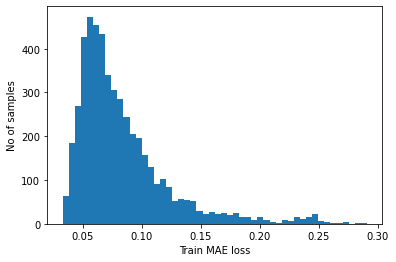

In [18]:
x_train_pred = model.predict(X_train_normal)
train_mae_loss = np.mean(np.abs(x_train_pred - X_train_normal), axis=1)

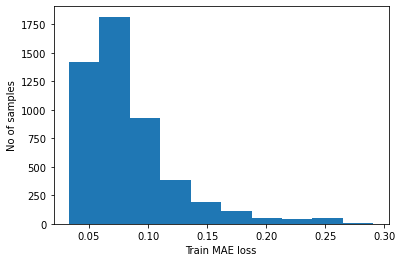

In [19]:
plt.hist(train_mae_loss, bins=10)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [24]:
x_train_pred.shape

(5000, 186, 1)

In [14]:
print(model.evaluate(X_train_normal,X_train_normal, verbose=3))
print(model.evaluate(X_train_anomaly2,X_train_anomaly2, verbose=3))
print(model.evaluate(X_train_anomaly3,X_train_anomaly3, verbose=3))
print(model.evaluate(X_train_anomaly4,X_train_anomaly4, verbose=3))

0.07351304590702057
0.09824233502149582
0.07396982610225677
0.089675173163414


### Conclusion and test set
It's clear that our model (trained on fewer samples than we have) detects most of the nomalies (except class 3). Now, let's do the same on the test set. We can set the decision boundary to `0.16`.

In [15]:
print(model.evaluate(X_test_normal,X_test_normal, verbose=3))
print(model.evaluate(X_test_anomaly,X_test_anomaly, verbose=3))
print(model.evaluate(X_test_anomaly2,X_test_anomaly2, verbose=3))
print(model.evaluate(X_test_anomaly3,X_test_anomaly3, verbose=3))
print(model.evaluate(X_test_anomaly4,X_test_anomaly4, verbose=3))

0.07309737056493759
0.07742656022310257
0.09911613911390305
0.07295534014701843
0.09004269540309906


In [24]:
from errormetrics import * 

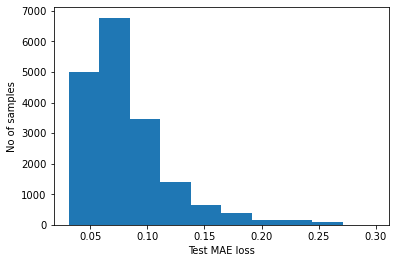

In [28]:
x_test_pred = model.predict(X_test_normal)
test_mae_loss = np.mean(np.abs(x_test_pred - X_test_normal), axis=1)
plt.hist(test_mae_loss, bins=10)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [33]:
predicted_bad = test_mae_loss[test_mae_loss>0.15]
predicted_ok = test_mae_loss[test_mae_loss<0.15]

"""
for sample in X_test_normal:
    if model.evaluate(sample, sample, verbose=3) > 0.08:
        predicted.append(1)
    else:
        predicted.append(0)
"""
print(len(predicted_ok))
print(len(predicted_bad))

17024
1094


In [31]:
print(len(predicted))

1094


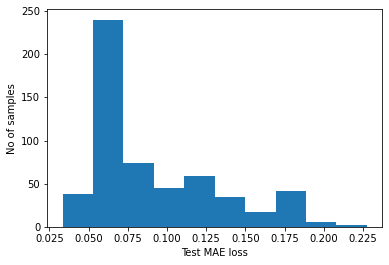

In [34]:
x_test_pred = model.predict(X_test_anomaly)
test_mae_loss = np.mean(np.abs(x_test_pred - X_test_anomaly), axis=1)
plt.hist(test_mae_loss, bins=10)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [35]:
#predicted_class1 = []


predicted_bad = test_mae_loss[test_mae_loss>0.15]
predicted_ok = test_mae_loss[test_mae_loss<0.15]

"""

print(len(predicted_ok))
print(len(predicted_bad))

for sample in X_test_anomaly:
    if model.evaluate(sample, sample, verbose=3) > 0.08:
        predicted_class1.append(1)
    else:
        predicted_class1.append(0)
"""

print(len(predicted_ok))
print(len(predicted_bad))

490
66


In [20]:
predicted_class2 = []

for sample in X_test_anomaly2:
    if model.evaluate(sample, sample, verbose=3) > 0.08:
        predicted_class2.append(1)
    else:
        predicted_class2.append(0)

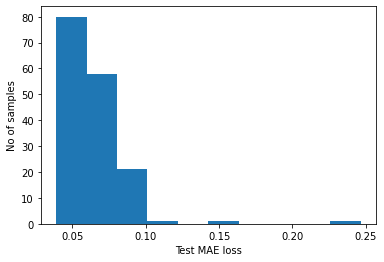

In [37]:
x_test_pred = model.predict(X_test_anomaly3)
test_mae_loss = np.mean(np.abs(x_test_pred - X_test_anomaly3), axis=1)
plt.hist(test_mae_loss, bins=10)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()



In [22]:
predicted_class4 = []

for sample in X_test_anomaly4:
    if model.evaluate(sample, sample, verbose=3) > 0.08:
        predicted_class4.append(1)
    else:
        predicted_class4.append(0)

### Computing precision, recall and F1-score

In [33]:
print(len(predicted))
print(sum(predicted))

print(len(predicted)-sum(predicted))

18118
18113
5


In [34]:
print(len(predicted_class1))
print(sum(predicted_class1))

print(len(predicted_class1)-sum(predicted_class1))

556
552
4


In [35]:
print(len(predicted_class2))
print(sum(predicted_class2))

print(len(predicted_class2)-sum(predicted_class2))

1448
1443
5


In [36]:
print(len(predicted_class3))
print(sum(predicted_class3))

print(len(predicted_class3)-sum(predicted_class3))

162
162
0


In [38]:
print(len(predicted_class4))
print(sum(predicted_class4))

print(len(predicted_class4)-sum(predicted_class4))

1608
1608
0


In [27]:
f1_m(predicted, y_test[y_test==0])

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:AddV2]

In [101]:
X_train = np.array([[0.5,0.7],[0.2,0.5],[0.5,0.7],[0.2,0.9]]).reshape(2, 2, 2)

In [102]:
X_train.shape

(2, 2, 2)

In [103]:
X_train

array([[[0.5, 0.7],
        [0.2, 0.5]],

       [[0.5, 0.7],
        [0.2, 0.9]]])

In [104]:
model.fit(X_train,X_train)

ValueError: in user code:

    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\engine\training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\engine\training.py:541 train_step  **
        self.trainable_variables)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\engine\training.py:1804 _minimize
        trainable_variables))
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:521 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:1219 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['lstm_46/lstm_cell_46/kernel:0', 'lstm_46/lstm_cell_46/recurrent_kernel:0', 'lstm_46/lstm_cell_46/bias:0', 'lstm_47/lstm_cell_47/kernel:0', 'lstm_47/lstm_cell_47/recurrent_kernel:0', 'lstm_47/lstm_cell_47/bias:0', 'lstm_48/lstm_cell_48/kernel:0', 'lstm_48/lstm_cell_48/recurrent_kernel:0', 'lstm_48/lstm_cell_48/bias:0', 'lstm_49/lstm_cell_49/kernel:0', 'lstm_49/lstm_cell_49/recurrent_kernel:0', 'lstm_49/lstm_cell_49/bias:0', 'time_distributed_9/kernel:0', 'time_distributed_9/bias:0'].


In [115]:
def define_models(n_input, n_output, n_units):
	# define training encoder
	encoder_inputs = Input(shape=(None, n_input))
	encoder = LSTM(n_units, return_state=True)
	encoder_outputs, state_h, state_c = encoder(encoder_inputs)
	encoder_states = [state_h, state_c]
	# define training decoder
	decoder_inputs = Input(shape=(None, n_output))
	decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
	decoder_dense = Dense(n_output, activation='softmax')
	decoder_outputs = decoder_dense(decoder_outputs)
	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
	# define inference encoder
	encoder_model = Model(encoder_inputs, encoder_states)
	# define inference decoder
	decoder_state_input_h = Input(shape=(n_units,))
	decoder_state_input_c = Input(shape=(n_units,))
	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
	decoder_states = [state_h, state_c]
	decoder_outputs = decoder_dense(decoder_outputs)
	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
	# return all models
	return model, encoder_model, decoder_model

In [116]:
m, _,_ = define_models(186,186, 1)

In [117]:
m.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, None, 186)]  0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, None, 186)]  0                                            
__________________________________________________________________________________________________
lstm_62 (LSTM)                  [(None, 1), (None, 1 752         input_21[0][0]                   
__________________________________________________________________________________________________
lstm_63 (LSTM)                  [(None, None, 1), (N 752         input_22[0][0]                   
                                                                 lstm_62[0][1]             

In [121]:
m.compile()
m.fit(X_train,X_train)

ValueError: in user code:

    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\engine\training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\engine\training.py:531 train_step  **
        y_pred = self(x, training=True)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\engine\network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\engine\network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:654 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:886 __call__
        self.name)
    c:\users\artem los\.conda\envs\tf_prod\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer lstm_62 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 186]
